**<font size = 5> Question 1 - Ruisi GENG**

In the process of solving question 1, though I was in a rush during my final exam, I gained a lot, including the initial research paper on how to implement the MIL method on the ground, searching for the latest papers in the field of MIL, the first contact with CNN's ReLU layer on how to implement activation from the code level, and other academic research experiences. To be honest, this is my first time using MIL based on CNN, and there are still a lot of shortcomings in many areas, and my understanding of the number of layers is not deep enough. Regardless of the results, I was pleasantly surprised by the effectiveness and creation of MIL in the paper and plan to use my vacation time to learn more about MI-CNN.

In [1]:
# Packages
import os
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

import argparse
from model import Model
from tqdm import tqdm

In [2]:
# Define the parameters
torch.manual_seed(1)  
EPOCH = 3             
BATCH_SIZE = 64
LR = 0.001              
DOWNLOAD_MNIST = False

In [3]:
# Mnist dataset
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,  #training data
    transform=torchvision.transforms.ToTensor(),    
    download=DOWNLOAD_MNIST,
)

C:\Users\dell\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([60000, 28, 28])
torch.Size([60000])


C:\Users\dell\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\dell\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


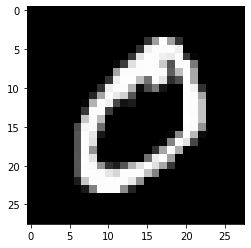

In [4]:
# Plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[1].numpy(), cmap='gray')

In [5]:
# Assume train a mini-batch (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True,num_workers=0)

# Pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)

###
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]

C:\Users\dell\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\dell\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [6]:
train_data_loader =  train_loader
val_data_loader = test_data 

In [7]:
model = Model(num_classes=10, num_instances=28, num_features=28, num_bins=7, sigma=0.05)

In [8]:
# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.01, weight_decay=0.0005)

In [9]:
# Define loss criterion
criterion = torch.nn.L1Loss()

In [10]:
# Model Training
for epoch in range(10):
    print('############## EPOCH - {} ##############'.format(epoch+1))
    training_loss = 0
    validation_loss = 0

    # Train for one epoch
    print('******** training ********')

    num_predictions = 0

    pbar = tqdm(total=len(train_data_loader))

    model.train()
    for images, targets in train_data_loader:
        images = images
        targets = targets
        print(images.shape)
        # Initialize the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y_logits = model(images)
        loss = criterion(y_logits, targets)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()*targets.size(0)
        num_predictions += targets.size(0)
        pbar.update(1)

    training_loss /= num_predictions
    pbar.close()

    # Evaluate the validation dataset
    print('******** validation ********')
    num_predictions = 0
    pbar = tqdm(total=len(val_data_loader))
    model.eval()
    with torch.no_grad():
        for images, targets in val_data_loader:
            images = images.to(device)
            targets = targets.to(device)

            # forward
            y_logits = model(images)
            loss = criterion(y_logits, targets)
            validation_loss += loss.item()*targets.size(0)
            num_predictions += targets.size(0)
            pbar.update(1)

    validation_loss /= num_predictions
    pbar.close()
    print('Epoch=%d ### training_loss=%5.3f ### validation_loss=%5.3f' % (epoch+1, training_loss, validation_loss))

  0%|          | 0/938 [00:00<?, ?it/s]

############## EPOCH - 1 ##############
******** training ********
torch.Size([64, 1, 28, 28])


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[64, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,          # n_filters
                kernel_size=5,               # filter size
                stride=1,                        # filter movement/step
                padding=2,                    # if want same width and length of this image after Conv2d, padding=(kernel_size-1)/2 if stride=1
            ),                                       # output shape (16, 28, 28)
            nn.ReLU(),                       # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(             # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),         # output shape (32, 14, 14)
            nn.ReLU(),                                 # activation
            nn.MaxPool2d(2),                      # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)                 # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    
        # return x for visualization

cnn = CNN()
print(cnn)  

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


C:\Users\dell\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch:  0 | train loss: 2.3002 | test accuracy: 0.15
Epoch:  0 | train loss: 0.5460 | test accuracy: 0.81
Epoch:  0 | train loss: 0.3154 | test accuracy: 0.89
Epoch:  0 | train loss: 0.1938 | test accuracy: 0.91
Epoch:  0 | train loss: 0.1287 | test accuracy: 0.93
Epoch:  0 | train loss: 0.2915 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1414 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1357 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0560 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0651 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1816 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0625 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1692 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1985 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1907 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0789 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1515 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0539 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0312 | test accuracy